In [81]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

#### Hyperparameters

In [82]:
EPOCHS = 5
LR = 0.1
INIT_W = 0.5
INIT_B = 0.5

#### Data Prep

In [83]:
FILE_PATH = "iris.data"
F = ["sepal_length","sepal_width","petal_length","petal_width"]

df = pd.read_csv(FILE_PATH, header=None, skip_blank_lines=True).dropna(axis=1, how="all").iloc[:, :5]
df.columns = F + ["species"]
df = df[df["species"].isin(["Iris-setosa","Iris-versicolor"])].reset_index(drop=True)

y = (df["species"].str.contains("versicolor", case=False)).astype(int).to_numpy()
X = df[F].astype(float).to_numpy()

i0, i1 = np.where(y==0)[0], np.where(y==1)[0]  # setosa / versicolor
tr_idx = np.r_[i0[:40], i1[:40]]; va_idx = np.r_[i0[40:50], i1[40:50]]

X_train, y_train = X[tr_idx], y[tr_idx]
X_val,   y_val   = X[va_idx], y[va_idx]

print(f"Train {X_train.shape} (y0={int((y_train==0).sum())}, y1={int((y_train==1).sum())}) | "
      f"Valid {X_val.shape} (y0={int((y_val==0).sum())}, y1={int((y_val==1).sum())})")

Train (80, 4) (y0=40, y1=40) | Valid (20, 4) (y0=10, y1=10)


#### Fungsi-fungsi SLP

In [84]:
def initialize_parameters(n_features, lr=LR):
    """Inisialisasi bobot dan bias"""
    weights = np.full(n_features, INIT_W, dtype=float)
    bias = float(INIT_B)
    return weights, bias, lr


def dot_product(inputs, weights, bias):
    """z = w·x + b"""
    return float(np.dot(inputs, weights) + bias)


def sigmoid(z):
    """Aktivasi sigmoid yang stabil untuk skalar z"""
    if z >= 0:
        ez = math.exp(-z)
        return 1.0 / (1.0 + ez)
    else:
        ez = math.exp(z)
        return ez / (1.0 + ez)


def predict_proba(X, weights, bias):
    """Hitung probabilitas kelas-1 (ŷ). Mendukung input 1D atau 2D."""
    X = np.asarray(X, dtype=float)
    if X.ndim == 1:
        # satu sampel
        z = np.dot(X, weights) + bias
        return 1.0 / (1.0 + np.exp(-z))
    else:
        # banyak sampel
        z = np.dot(X, weights) + bias
        return 1.0 / (1.0 + np.exp(-z))


def predict_label(X, weights, bias, threshold=0.5):
    """Konversi probabilitas ke label 0/1 dengan ambang."""
    p = predict_proba(X, weights, bias)
    return (p >= threshold).astype(int) if np.ndim(p) > 0 else int(p >= threshold)


def square_error_mean(y_true, y_prob):
    """MSE = mean((ŷ - y)^2)."""
    y_true = np.asarray(y_true, dtype=float)
    y_prob = np.asarray(y_prob, dtype=float)
    return float(np.mean((y_prob - y_true) ** 2))


def evaluate_end_of_epoch(X, y, w, b, threshold=0.5):
    """Evaluasi loss & akurasi dengan bobot terakhir (untuk validasi)."""
    probs = predict_proba(X, w, b)
    loss = square_error_mean(y, probs)
    preds = (probs >= threshold).astype(int) if np.ndim(probs) > 0 else int(probs >= threshold)
    acc = float(np.mean(preds == y))
    return loss, acc

#### Training

In [85]:
def train(X_train, y_train, X_val, y_val, lr=LR, epochs=EPOCHS):
    w, b, lr = initialize_parameters(X_train.shape[1], lr)
    logs = []

    for epoch in range(1, epochs + 1):
        # --- akumulasi metrik TRAIN ---
        total_train_loss = 0.0
        correct_train = 0

        for x_i, y_i in zip(X_train, y_train):
            # prediksi sebelum update
            z = dot_product(x_i, w, b)
            y_hat = sigmoid(z)

            # akumulasi metrik TRAIN
            total_train_loss += (y_hat - y_i) ** 2
            correct_train    += (1 if (y_hat >= 0.5) == (y_i == 1) else 0)

            # hitung grad & UPDATE (SGD)
            grad = 2.0 * (y_hat - y_i) * y_hat * (1.0 - y_hat)
            w = w - lr * grad * x_i
            b = b - lr * grad

        # rata-rata TRAIN
        train_loss = total_train_loss / len(X_train)
        train_acc  = correct_train / len(X_train)

        # VALID dievaluasi di AKHIR epoch (pakai bobot terakhir)
        val_loss, val_acc = evaluate_end_of_epoch(X_val, y_val, w, b)

        logs.append({
            "epoch": epoch,
            "train_loss": float(train_loss),
            "train_acc": float(train_acc),
            "val_loss": float(val_loss),
            "val_acc": float(val_acc),
        })

        print(f"Epoch {epoch:2d} | Train Loss={train_loss:.6f} | Train Acc={train_acc:.4f} | "
              f"Val Loss={val_loss:.6f} | Val Acc={val_acc:.4f}")

    return w, b, pd.DataFrame(logs)


#### Run

In [86]:
w, b, history = train(X_train, y_train, X_val, y_val, lr=LR, epochs=EPOCHS)

print("\nHistory (head):")
print(history.head())

Epoch  1 | Train Loss=0.449889 | Train Acc=0.5250 | Val Loss=0.328951 | Val Acc=0.5000
Epoch  2 | Train Loss=0.037452 | Train Acc=0.9500 | Val Loss=0.247289 | Val Acc=0.5000
Epoch  3 | Train Loss=0.024372 | Train Acc=0.9750 | Val Loss=0.175892 | Val Acc=0.5000
Epoch  4 | Train Loss=0.017357 | Train Acc=0.9750 | Val Loss=0.119381 | Val Acc=0.8500
Epoch  5 | Train Loss=0.012740 | Train Acc=0.9875 | Val Loss=0.081581 | Val Acc=1.0000

History (head):
   epoch  train_loss  train_acc  val_loss  val_acc
0      1    0.449889     0.5250  0.328951     0.50
1      2    0.037452     0.9500  0.247289     0.50
2      3    0.024372     0.9750  0.175892     0.50
3      4    0.017357     0.9750  0.119381     0.85
4      5    0.012740     0.9875  0.081581     1.00


#### Plot

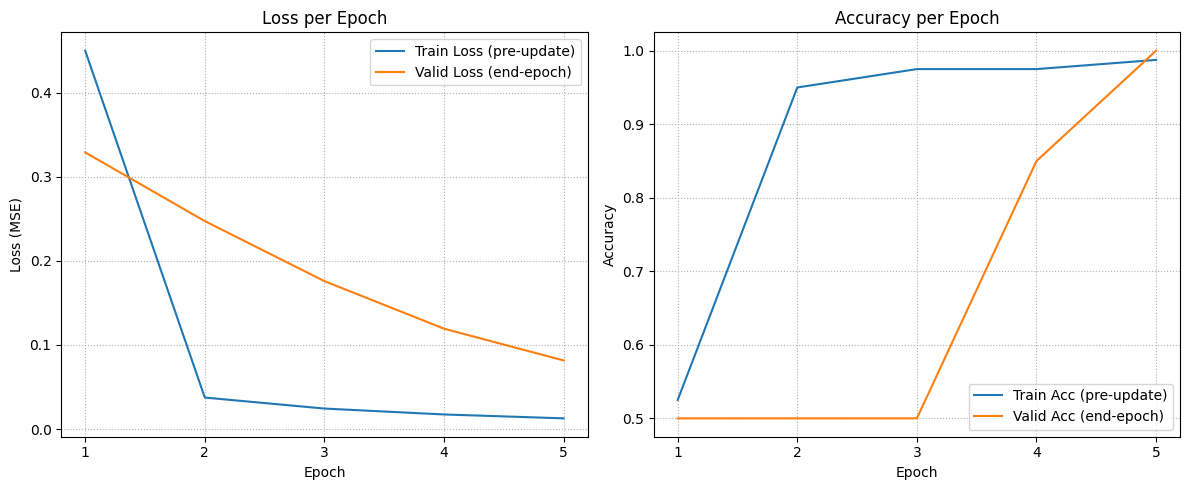

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(history['epoch'], history['train_loss'], label='Train Loss (pre-update)')
ax[0].plot(history['epoch'], history['val_loss'],   label='Valid Loss (end-epoch)')
ax[0].set_title("Loss per Epoch"); ax[0].set_xlabel("Epoch"); ax[0].set_ylabel("Loss (MSE)")
ax[0].grid(True, linestyle=":"); ax[0].legend(); ax[0].set_xticks(history['epoch'])

ax[1].plot(history['epoch'], history['train_acc'], label='Train Acc (pre-update)')
ax[1].plot(history['epoch'], history['val_acc'],   label='Valid Acc (end-epoch)')
ax[1].set_title("Accuracy per Epoch"); ax[1].set_xlabel("Epoch"); ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle=":"); ax[1].legend(); ax[1].set_xticks(history['epoch'])

plt.tight_layout(); plt.show()